In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats
from scipy import stats
from scipy.stats import ttest_rel
from scipy.stats import ttest_ind
from scipy.stats import shapiro
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu

from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.stattools import omni_normtest

from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.api import qqplot, add_constant

from sklearn.preprocessing import scale, minmax_scale, robust_scale
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from statsmodels.tools.eval_measures import rmse

%matplotlib inline
sns.set(font="AppleGothic")
plt.rcParams['axes.unicode_minus']=False

# 0. 데이터 로드


In [78]:
df = pd.read_csv('체질검사.csv', engine='python', encoding='cp949')
df.head(n=3)

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
0,35.2,46,363.15,72.25,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4
1,11.8,27,168.00,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8
2,22.2,69,177.75,68.50,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8


# 1. 경향성 확인
## 1-1. 산점도 분석
### 해석: 

- 종속 변수 FAT과 몸무게, 목둘레, 가슴둘레, 복부둘레는 양의 상관 관계를 가진다.

    - 그 중 1개 데이터가 전체 산점도에서 분포가 벗어나있기 때문에, 이상치일 가능성이 있다.


- 'FAT'과 선형 관계가 있는 변수는 'AGE'와 'HEIGHT'를 제외한 모든 변수이다.

    <'FAT'과 선형 관계가 있는 변수>
    
     'WEIGHT',
     'NECK',
     'CHEST',
     'ABDOMEN',
     'HIP',
     'THIGH',
     'KNEE',
     'ANKLE',
     'BICEPS',
     'FOREARM',
     'WRIST'

- 그러나 설명 변수들간 선형성이 있다. 따라서 다중 공선성을 확인해야할 필요성이 있다.

- 설명 변수들의 분포가 정규분포에 근사하는 분포를 보인다.

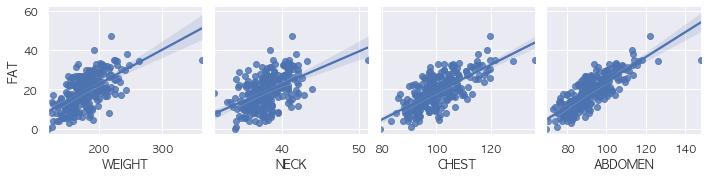

In [7]:
sns.pairplot(df, y_vars='Y', x_vars=['WEIGHT','NECK','CHEST','ABDOMEN'], kind='reg', diag_kind=None)

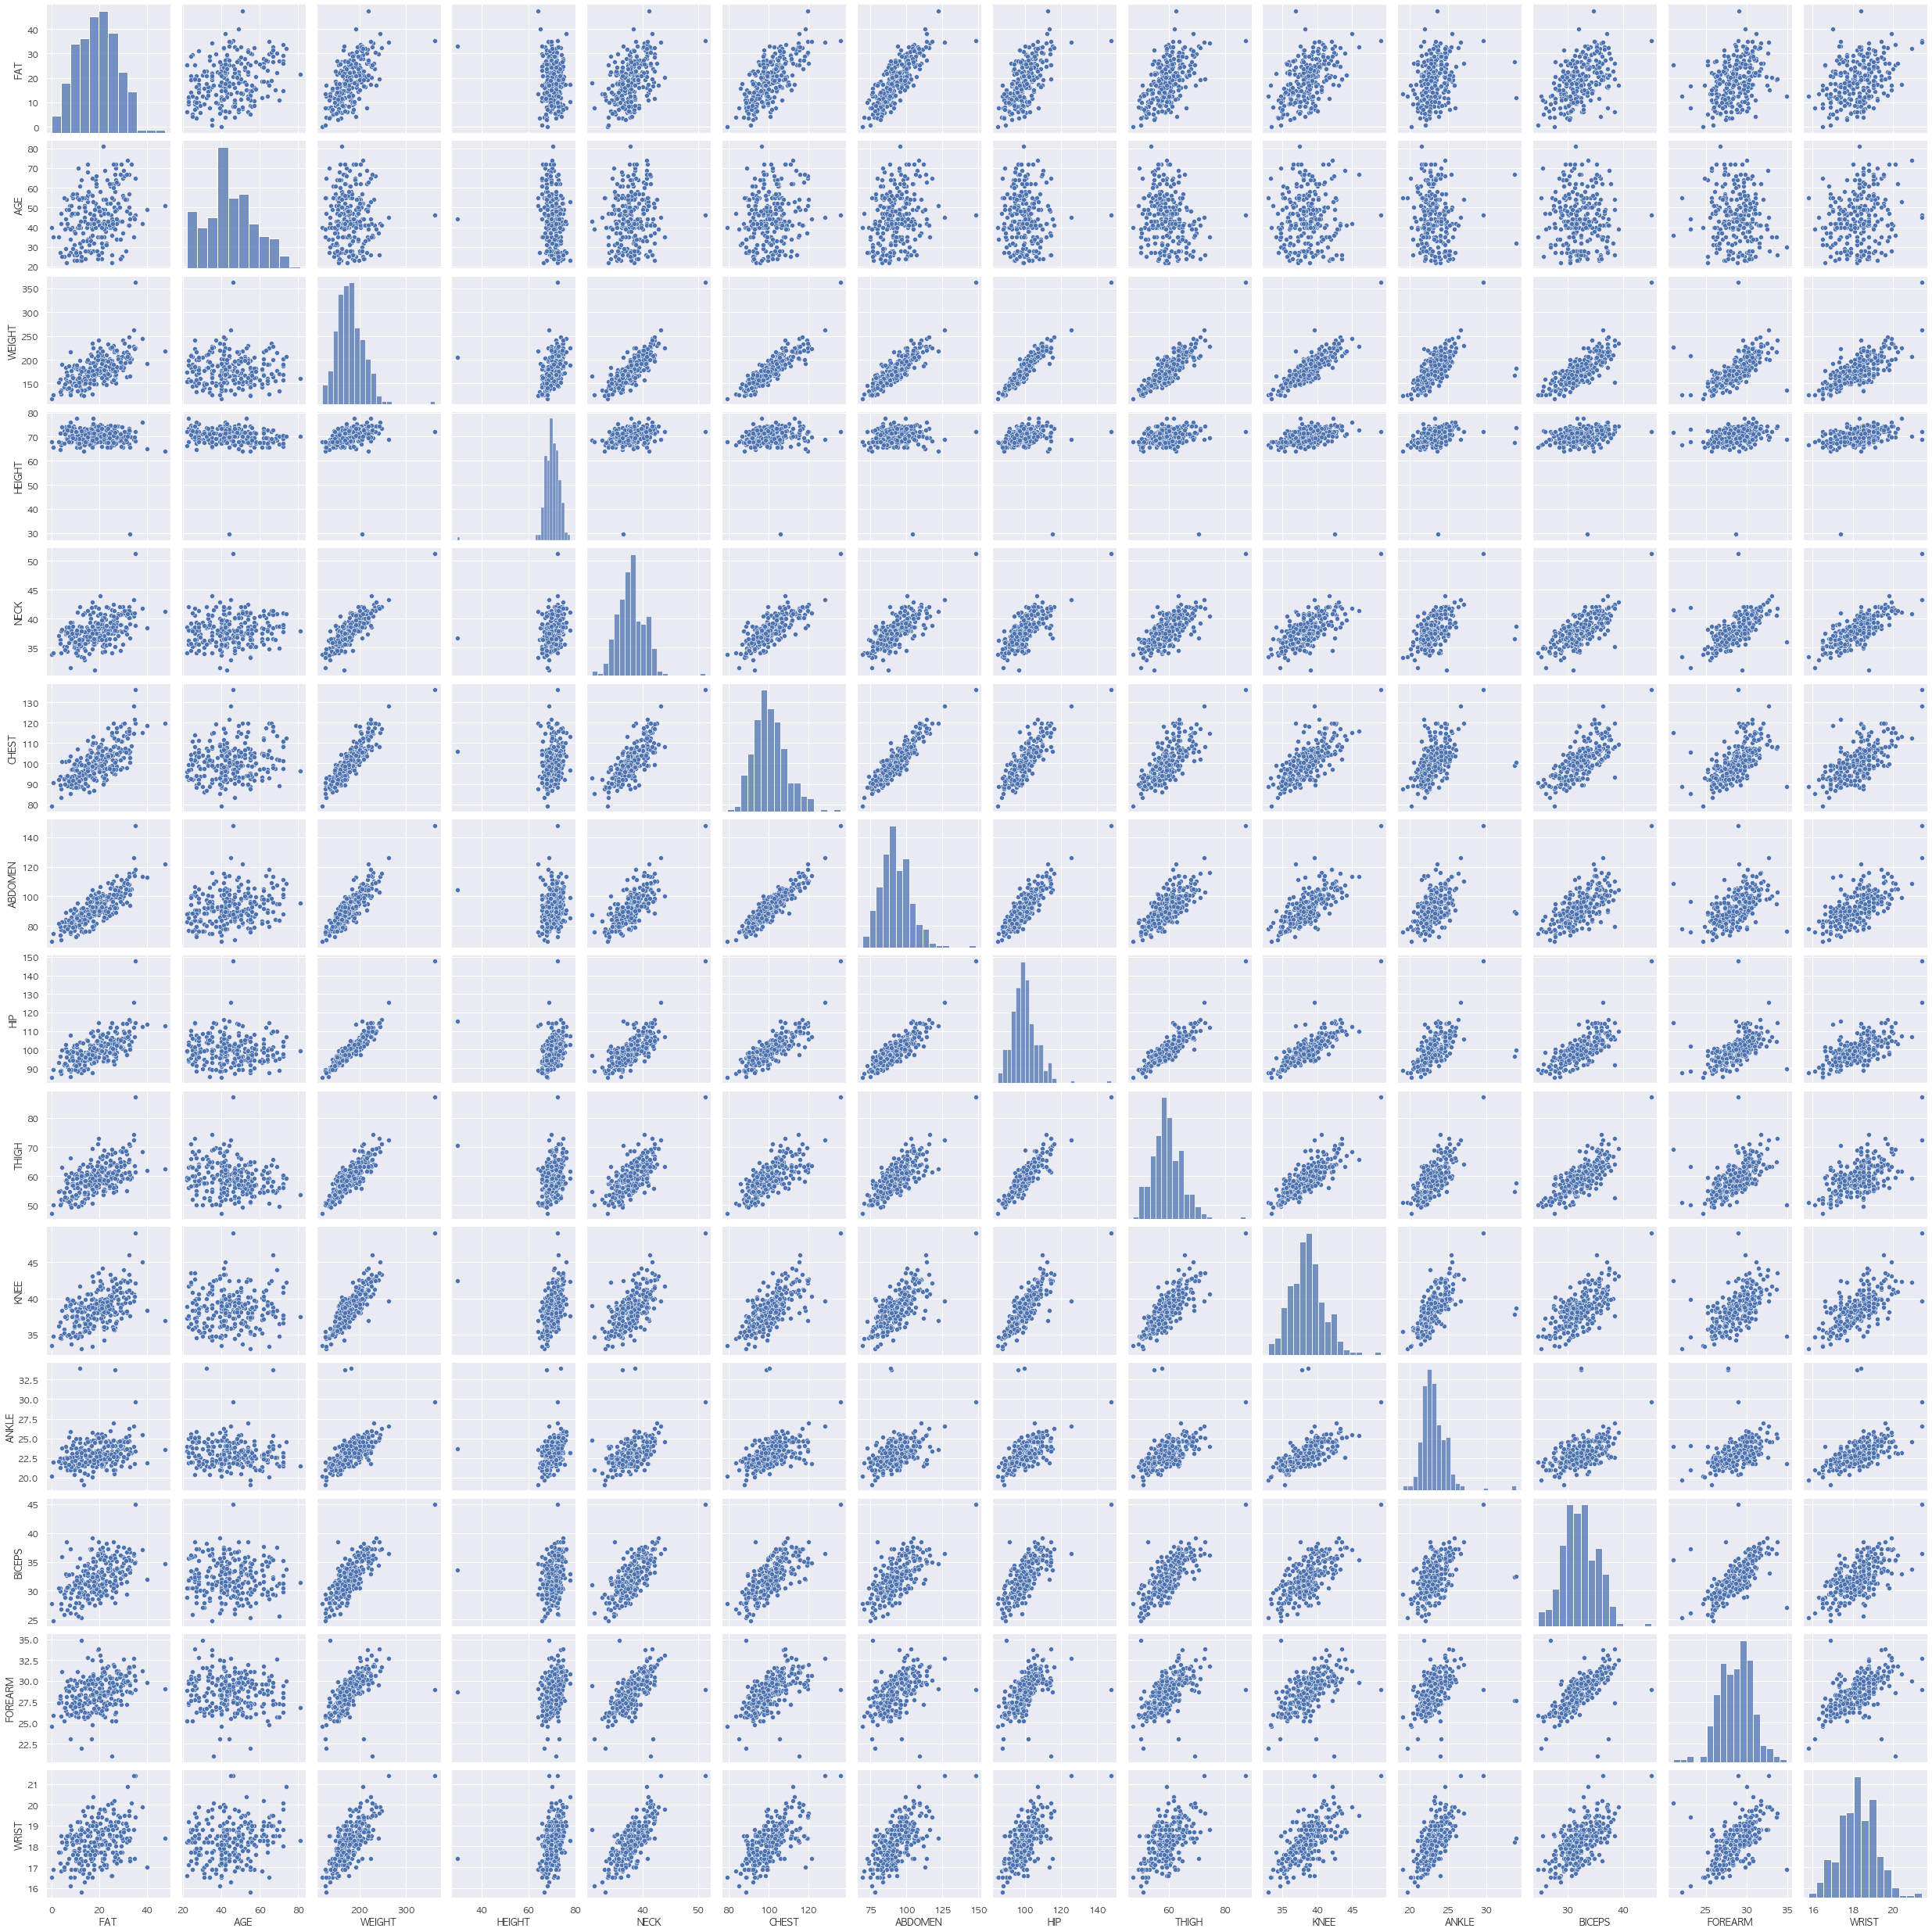

In [59]:
sns.pairplot(df)

## 1-2. 상관관계 분석
### 해석: 

FAT과 양의 상관관계를 가지는 변수들을 상관도가 높은 순서로 정리하면 다음과 같다.
ABDOMEN>CHEST>HIP>WEIGHT>THIGH>KNEE>BICEPS>NECK>FOREARM>WRIST>AGE>ANKLE

특히 FAT과 CHEST와 HIP은 양의 상관관계가 크다.

In [31]:
df.corr()

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
FAT,1.000000,0.291458,0.612414,-0.089495,0.490592,0.702620,0.813432,0.625201,0.559608,0.508665,0.265970,0.493271,0.361387,0.346575
AGE,0.291458,1.000000,-0.012746,-0.171645,0.113505,0.176450,0.230409,-0.050332,-0.200096,0.017516,-0.105058,-0.041162,-0.085056,0.213531
WEIGHT,0.612414,-0.012746,1.000000,0.308279,0.830716,0.894191,0.887995,0.940884,0.868694,0.853167,0.613685,0.800416,0.630301,0.729775
HEIGHT,-0.089495,-0.171645,0.308279,1.000000,0.253710,0.134892,0.087813,0.170394,0.148436,0.286053,0.264744,0.207816,0.228649,0.322065
NECK,0.490592,0.113505,0.830716,0.253710,1.000000,0.784835,0.754077,0.734958,0.695697,0.672405,0.477892,0.731146,0.623660,0.744826
CHEST,0.702620,0.176450,0.894191,0.134892,0.784835,1.000000,0.915828,0.829420,0.729859,0.719496,0.482988,0.727907,0.580173,0.660162
ABDOMEN,0.813432,0.230409,0.887995,0.087813,0.754077,0.915828,1.000000,0.874066,0.766624,0.737179,0.453223,0.684983,0.503316,0.619832
HIP,0.625201,-0.050332,0.940884,0.170394,0.734958,0.829420,0.874066,1.000000,0.896410,0.823473,0.558387,0.739273,0.545014,0.630090
THIGH,0.559608,-0.200096,0.868694,0.148436,0.695697,0.729859,0.766624,0.896410,1.000000,0.799170,0.539797,0.761477,0.566842,0.558685
KNEE,0.508665,0.017516,0.853167,0.286053,0.672405,0.719496,0.737179,0.823473,0.799170,1.000000,0.611608,0.678709,0.555898,0.664507


In [66]:
# FAT과 선형 관계를 가지는 변수들을 상관성이 높은 순서대로 정렬하기.
vs = df.corr().loc['FAT':'FAT'].values.tolist()[0]
cols = df.corr().loc['FAT':'FAT'].columns.tolist()

l = []
for idx, (c, v) in enumerate(zip(cols,vs)):
    l.append([c, v])
    
for x in sorted(l, key=lambda x: x[1], reverse=True):
    print(x[0], x[1])

FAT 1.0
ABDOMEN 0.8134322847810488
CHEST 0.702620338893864
HIP 0.625200917508663
WEIGHT 0.6124140022026471
THIGH 0.5596075319940899
KNEE 0.5086652428854678
BICEPS 0.49327112589161565
NECK 0.49059185344104006
FOREARM 0.36138690319971917
WRIST 0.34657486452658604
AGE 0.2914584401352219
ANKLE 0.26596977030637337
HEIGHT -0.08949537985440179


# 2.모델 적합성 확인

# 2-0.파생변수 생성: BMI
![image.png](attachment:image.png)

Text(0.5, 0, 'count')

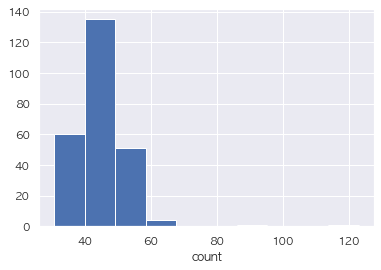

In [80]:
# df['WEIGHT']*0.45 #[kg]
# df['HEIGHT']*2.54*0.01 #[m]
df['BMI'] = df['WEIGHT']*0.45/(df['HEIGHT']*2.54*0.01) # 단위 [kg/m**2]
plt.hist(df['BMI'])
plt.xlabel('BMI')
plt.xlabel('count')

In [81]:
df

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,BMI
0,35.2,46,363.15,72.25,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4,89.048579
1,11.8,27,168.00,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8,41.773726
2,22.2,69,177.75,68.50,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8,45.972470
3,10.6,57,147.75,65.75,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9,39.811682
4,47.5,51,219.00,64.00,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4,60.623770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,31.9,74,207.50,70.00,40.8,112.4,108.5,107.1,59.3,42.2,24.6,33.7,30.0,20.9,52.516873
248,23.6,43,170.75,67.50,37.4,103.7,89.7,94.2,58.5,39.0,24.1,33.8,28.8,18.8,44.816273
249,20.9,35,162.75,66.00,36.4,99.1,92.8,99.2,63.1,38.7,21.7,31.1,26.4,16.9,43.687366
250,17.0,56,167.75,68.50,37.4,98.6,93.0,97.0,55.4,38.8,23.2,32.4,29.7,19.0,43.386114


# 2-1.모델 적합성 확인
### 해석:
- 분산 분석 결과: F 통계량 값이 매우 크고, p-value가 0이므로 H0기각=> 다중회귀 모델로서 유의수준 5%에서 유의하다.
    - F-statistic:                     50.61
    - Prob (F-statistic):           5.07e-63
- R-squared: 모델로 FAT 변수를 74.9% 설명할 수 있다.
- 회귀계수 검정 결과:
    - 여러 회귀 계수 중에 p-value가 0.05보다 작은 변수는 복부(0.000), 팔뚝(0.026), 손목(0.003)으로 FAT 설명변수로서 유의하다.

In [93]:
model = smf.ols(formula='FAT ~ AGE+WEIGHT+HEIGHT+NECK+CHEST+ABDOMEN+HIP+THIGH+KNEE+ANKLE+BICEPS+FOREARM+WRIST+BMI', data=df)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     50.61
Date:                Mon, 23 Aug 2021   Prob (F-statistic):           5.07e-63
Time:                        23:12:35   Log-Likelihood:                -718.10
No. Observations:                 252   AIC:                             1466.
Df Residuals:                     237   BIC:                             1519.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -29.2532     27.035     -1.082      0.2

# 다중공선성 확인

가슴, 복부, 키, 엉덩이, BMI, 몸무게의 VIF 값이 10을 넘는다.=> 다중 공선성을 가진다.

다중 공선성이 가장 높은 변수는 몸무게이다.


In [92]:
x=df.drop('FAT', axis=1)
x_const = add_constant(x)
df_vif = pd.DataFrame()
df_vif['variable'] = x_const.columns
df_vif['VIF']=[variance_inflation_factor(x_const.values, i) for i in range(x_const.shape[1])]
df_vif.sort_values('VIF', inplace=True)
df_vif.round(3)

,variable,VIF
10,ANKLE,1.920
12,FOREARM,2.199
1,AGE,2.252
13,WRIST,3.378
11,BICEPS,3.674
4,NECK,4.457
9,KNEE,4.797
8,THIGH,8.003
5,CHEST,10.066
6,ABDOMEN,12.570


# 다중 공선성 높은 변수 제거 후 재확인
다중 공선성 높은 변수는 BMI지수, 복부, 엉덩이로 3개로 감소하였으며, 

다른 변수들의 다중공선성이 전체적으로 감소하였다.

📌특히 BMI 지수는 여전히 다중 공산성이 10이상으로 높은데, 이는 다른 변수들의 조합으로 이루어진 변수이기 때문일 것으로 해석된다.

In [91]:
x=df.drop(['FAT', 'WEIGHT'], axis=1)
x_const = add_constant(x)
df_vif = pd.DataFrame()
df_vif['variable'] = x_const.columns
df_vif['VIF']=[variance_inflation_factor(x_const.values, i) for i in range(x_const.shape[1])]
df_vif.sort_values('VIF', inplace=True)
df_vif.round(3)

,variable,VIF
9,ANKLE,1.863
11,FOREARM,2.196
1,AGE,2.227
12,WRIST,3.349
10,BICEPS,3.524
2,HEIGHT,3.828
3,NECK,4.030
8,KNEE,4.797
7,THIGH,7.777
4,CHEST,8.183


# 다중공선성이 높은 변수를 제거한 후 다시 다중 선형 회귀 적합 실험
### 해석: 변수 제거 후 변화는?

- 분산 분석 결과: F 통계량 값이 매우 크고, p-value가 0이므로 H0기각=> 다중회귀 모델로서 유의수준 5%에서 여전히 유의하다.
    - F-statistic:                     54.13
    - Prob (F-statistic):           1.79e-63
    
- R-squared: 모델로 FAT 변수 설명하는 설명력이 74.9%-> 74.7%로 소량 감소
    - 다중 공선성이 큰 변수를 제거하였으므로 설명력이 소량 감소하였다.
    - 이를 통해 제거한 변수의 종속변수 설명력이 불필요 했다고 해석하였다.
    
- 회귀계수 검정 결과:
    - 변수 제거 전 FAT 설명변수로서 유의했던 "복부(0.000->0.000), 팔뚝(0.023), 손목(0.002)"의 p-value가 더 감소했다=> 더 유의해졌다.
    - 변수 제거 후 p-value가 0.05보다 작은 변수가 "나이, 목"으로 추가되었다.
    
- 📌BMI 지수는 p-value가 0.315으로 0.05보다 크므로 H0채택 => 유의하지 않다.

In [94]:
model = smf.ols(formula='FAT ~ AGE+HEIGHT+NECK+CHEST+ABDOMEN+HIP+THIGH+KNEE+ANKLE+BICEPS+FOREARM+WRIST+BMI', data=df)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     54.13
Date:                Mon, 23 Aug 2021   Prob (F-statistic):           1.79e-63
Time:                        23:13:17   Log-Likelihood:                -719.15
No. Observations:                 252   AIC:                             1466.
Df Residuals:                     238   BIC:                             1516.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.3098      7.675      0.952      0.3

# 후진제거법을 통한 변수 선택
### 해석: 선택된 변수와 제거된 변수는?

앞서 모델 피팅 결과에서 상관 계수로서 변수의 p-value를 살펴보았을 때 유의했던 변수인 복부, 팔뚝, 손목이 선택되어있다.

반면 추가로 유의한 변수에 들었던, 나이는 제거되었다.

📌BMI 지수는 유의하지 않기 때문에 예상대로 제거되었다.

In [96]:
y = df['FAT']
model = LinearRegression()
rfe = RFE(estimator=model, n_features_to_select=5).fit(x,y)
selected_x = x.columns[rfe.support_]
removed_x = x.columns[~rfe.support_]
print('선택 변수', selected_x)
print('제거 변수',removed_x)

선택 변수 Index(['NECK', 'ABDOMEN', 'HIP', 'FOREARM', 'WRIST'], dtype='object')
제거 변수 Index(['AGE', 'WEIGHT', 'HEIGHT', 'CHEST', 'THIGH', 'KNEE', 'ANKLE', 'BICEPS',
       'BMI'],
      dtype='object')


# 후진제거법 이후 모델 피팅 결과
### 해석: 변수 제거 후 변화는?

- 분산 분석 결과: F 통계량 값이 매우 증가, p-value가 0으로 더 수렴하였다=> H0기각=> 다중회귀 모델로서 유의수준 5%에서 여전히 유의하다.
    - F-statistic:                     133.8
    - Prob (F-statistic):           4.38e-68
    
- R-squared: 모델로 FAT 변수 설명하는 설명력이 74.7%->73.1%로 감소
    - 여러 변수를 제거하였으므로 설명력이 감소하였다.
    - 하지만 감소의 정도는 1%정도로, 제거한 9개 변수의 설명력이 크지 않았던 것으로 해석된다.
    
- 회귀계수 검정 결과:
    - "목, 복부, 엉덩이, 팔뚝, 손목"의 p-value가 더 감소했다=> 더 유의해졌다.

In [97]:
model = smf.ols(formula='FAT ~ NECK+ABDOMEN+HIP+FOREARM+WRIST', data=df)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     133.8
Date:                Mon, 23 Aug 2021   Prob (F-statistic):           4.38e-68
Time:                        23:36:30   Log-Likelihood:                -726.92
No. Observations:                 252   AIC:                             1466.
Df Residuals:                     246   BIC:                             1487.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.7037      6.231      0.434      0.6

# 3.회귀계수 계산 및 확인
비만도는 {손목 두께, 엉덩이둘레,목 둘레}가 얇을수록, {복부 둘레, 팔뚝 둘레}가 증가할수록 높다. 

In [ ]:
FAT = 2.7037 + (-0.6012)*목 + 0.9743*복부+ (-0.3316)*엉덩이 +(0.4095)*팔뚝 + (-1.6180)*손목

# 4.잔차 분석
### 잔차의 등분산성 검정
해석:
잔차들이 0을 중심으로 각각 **y = 0을 기준으로 랜덤하게 분포**한다.=>등분산성 만족

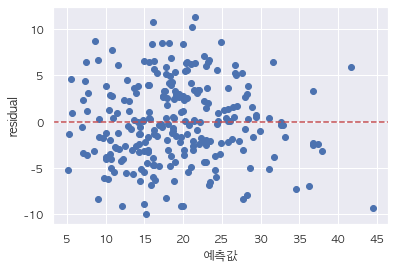

In [98]:
plt.scatter(result.fittedvalues, result.resid)
plt.xlabel('예측값')
plt.ylabel('residual')
plt.axhline(y=0, linestyle = '--', c='r')
plt.show()
plt.close()

### 잔차의 독립성 검정
Durbin-wawtson(독립성) 검정 통계량 2.128로 2에 가까우므로 =>독립성을 만족한다.

### 잔차의 정규성 검정
- Prob(Omnibus): p-value = 0.158으로 유의수준 5%에서 귀무가설을 채택한다.=>정규성을 따른다


# 5. 모델 선정

# 표준화 회귀 계수를 이용한 변수 중요도 확인
회귀 모델에서 중요도가 가장 큰 것은 복부 둘레이다.

<AxesSubplot:>

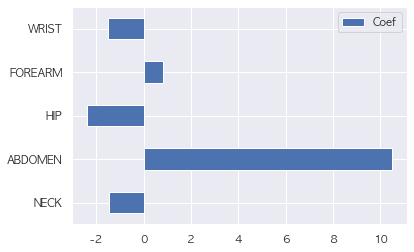

In [113]:
# 설명 변수 표준화
scaler = StandardScaler()
cols = x.columns

# 설명 변수의 scale 변환
np_scaled = scaler.fit_transform(x)
df_scaled = pd.DataFrame(np_scaled, columns=cols)

df_scaled['FAT'] = df['FAT']

model_scaled = smf.ols(formula='FAT ~ NECK+ABDOMEN+HIP+FOREARM+WRIST', data=df_scaled)
result_scaled = model_scaled.fit()

coef = pd.DataFrame({'Coef': result_scaled.params.values[1:]}, index = selected_x)
coef.plot.barh(y='Coef', legend=True)